## SIFT + Bag of Visual Words

Sacado de https://github.com/gurkandemir/Bag-of-Visual-Words/blob/master/Code%20Files/BoW.py

In [2]:
import argparse
import cv2
import numpy as np 
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score ,ConfusionMatrixDisplay



In [3]:
from funciones import make_dataset, split_train_test, get_classes

In [4]:
dir_imagenes_5="images_5/"
dir_labels_5="annotations_5/trimaps_5/"
dir_imagenes="images/"
dir_labels="annotations/trimaps/"
dir_images_small="images_small/"

In [5]:
# def getFiles(train, path):
#     images = []
#     for folder in os.listdir(path):
#         for file in  os.listdir(os.path.join(path, folder)):
#             images.append(os.path.join(path, os.path.join(folder, file)))

#     if(train is True):
#         np.random.shuffle(images)
    
#     return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path, direccion_lbl):
    img = cv2.imread(img_path, 0)
    nombre_archivo_mascara = os.path.splitext(img_path)[0] + '.png'
    ruta_mascara = os.path.join(direccion_lbl, nombre_archivo_mascara)
    print(ruta_mascara)
    mascara = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)
    #probar cual queda  mejor
    #mascara_binaria = cv2.compare(mascara, 1, cv2.CMP_EQ) | cv2.compare(mascara, 3, cv2.CMP_EQ)
    mascara_binaria = cv2.compare(mascara, 1, cv2.CMP_EQ) 
    imagen_sin_fondo = cv2.bitwise_and(img, img, mask=mascara_binaria)
    return cv2.resize(imagen_sin_fondo,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    # class_weight = {
    #     0: (807 / (7 * 140)),
    #     1: (807 / (7 * 140)),
    #     2: (807 / (7 * 133)),
    #     3: (807 / (7 * 70)),
    #     4: (807 / (7 * 42)),
    #     5: (807 / (7 * 140)),
    #     6: (807 / (7 * 142)) 
    # }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    # cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(classes))
    # cmd.plot()



def plotConfusions(true, predictions ):
    np.set_printoptions(precision=2)

    plotConfusionMatrix(true, predictions, classes=list(set(predictions)),
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=list(set(predictions)), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

def trainModel(images,labels, no_clusters, kernel):
    sift = cv2.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    image_count = len(images)

    for img_path, class_index in zip(images, labels):
 

        train_labels = np.append(train_labels, class_index)
        try:
            img = readImage(img_path)
            des = getDescriptors(sift, img)
            descriptor_list.append(des)
        except:
            print(img_path)
    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

def testModel(test_images, test_labels,kmeans, scale, svm, im_features, no_clusters, kernel, class_names):

    count = 0
    true = []
    descriptor_list = []
    name_dict = {str(i): class_names[i] for i in range(len(class_names))}
    print(name_dict)

    sift = cv2.SIFT_create()

    for img_path, label in zip(test_images, test_labels):
        img = readImage(img_path, dir_labels)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)
            true.append(label)

    #descriptors = vstackDescriptors(descriptor_list)


    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    print(svm.predict(kernel_test))
    
    #predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    #predictions = [k for k, v in name_dict.items() if v in svm.predict(kernel_test)]
    predictions = []
    for value in svm.predict(kernel_test):
        for k, v in name_dict.items():
            if v == value:
                predictions.append(k)
                break
    print(predictions)
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

def execute(images_train, images_test, classes_train, classes_test, no_clusters, kernel, classes):
    
    kmeans, scale, svm, im_features = trainModel(images_train,classes_train, no_clusters, kernel)
    testModel(images_test, classes_test, kmeans, scale, svm, im_features, no_clusters, kernel, classes)

Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


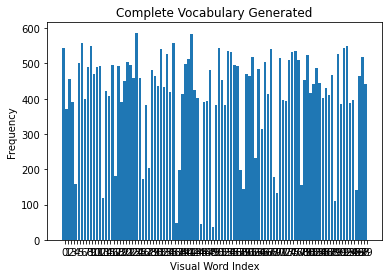

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
{'0': 'Bombay', '1': 'Abyssinian', '2': 'Russian_Blue', '3': 'Bengal', '4': 'Persian', '5': 'Maine_Coon', '6': 'Siamese', '7': 'British_Shorthair', '8': 'Ragdoll', '9': 'Sphynx', '10': 'Birman', '11': 'Egyptian_Mau'}
['Birman' 'Siamese' 'Bengal' 'Birman' 'Ragdoll' 'Siamese' 'Birman'
 'British_Shorthair' 'Abyssinian' 'Persian' 'British_Shorthair' 'Sphynx'
 'Abyssinian' 'Maine_Coon' 'British_Shorthair' 'Egyptian_Mau' 'Bengal'
 'Bombay' 'British_Shorthair' 'Bengal' 'Bombay' 'British_Shorthair'
 'Abyssinian' 'Abyssinian' 'Bengal' 'Russian_Blue' 'Ragdoll' 'Ragdoll'
 'Bengal' 'British_Shorthair' 'Russian_Blue' 'Persian' 'Russian_Blue'
 'Birman' 'Bombay' 'Bombay' 'British_Shorthair' 'Russian_Blue' 'Bombay'
 'Maine_Coon' 'Russian_Blue' 'Birman' 'Sphynx' 'Ragdoll' 'Bombay'
 'Siamese' 'Bengal' 'British_Shorthair' 'Birman' 'Ragdoll'
 'British_Shorthair' 'British_Shorthair' 'Abyssinian' 'Russian_Blue'
 'Ragdoll' 'Persian' 'British

/tmp/ipykernel_116746/2766640047.py:100: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [7]:
nombre_csv="datos_gatos.csv"
#make_dataset(dir_imagenes, nombre_csv)

df = pd.read_csv(nombre_csv)
df=df[df['Family'] == 'Gato']
images_train, images_test, classes_train, classes_test=split_train_test(df, 0.9)
classes=get_classes(df)
no_clusters=100
kernel="precomputed"
execute(images_train, images_test, classes_train, classes_test, no_clusters, kernel, classes)